# BM25 Retrieval

## Sentence-Level/Paragraph-Level

In [ ]:
import pandas as pd
from langchain.retrievers import BM25Retriever
from langchain.schema import Document

class BM25RetrieverWrapper:
    def __init__(self, documents):
        # Filter out very short lines and convert them into Document objects
        self.documents = [
            Document(page_content=line.strip(), metadata={"id": idx})
            for idx, line in enumerate(documents)
            if len(line.strip()) > 2
        ]
        self.retriever = BM25Retriever.from_documents(self.documents)

    def retrieve_topk(self, query, topk):
        self.retriever.k = topk
        return self.retriever.invoke(query)  # invoke() is preferred

def load_documents(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        return [line.strip() for line in file if len(line.strip()) > 5]

def main():
    data_dir = "../data/MSE-KG/"
    # triples_path = data_dir + "verbalized_triples_np.txt"
    triples_path = data_dir + "KGPreprocess/verbalized_paragraphs.txt"
    questions_path = data_dir + "KG_QA/Competency_Question.xlsx"

    try:
        # Load documents and initialize BM25 retriever
        document_lines = load_documents(triples_path)
        bm25_model = BM25RetrieverWrapper(document_lines)

        # Load questions and ground truth
        questions_df = pd.read_excel(questions_path)

        if questions_df.shape[1] < 2:
            raise ValueError("Input Excel must have at least two columns: question and ground truth.")

        for top_k in range(10, 101, 10):
            # Keep the first two columns: question and ground truth
            results_df = questions_df.iloc[:, [0, 1]].copy()
            results_df.columns = ['Competency Question', 'Ground Truth']

            # Retrieve BM25 contexts for each question
            queries = questions_df.iloc[:, 0]
            results = [
                "\n".join([doc.page_content for doc in bm25_model.retrieve_topk(query, top_k)])
                for query in queries
            ]
            results_df['Contexts'] = results

            output_path = f"{data_dir}BM25/contexts_by_bm25_{top_k}_paragraph_level.xlsx"
            results_df.to_excel(output_path, index=False)
            print(f"Saved: {output_path} (Columns: Competency Question, Ground Truth, Contexts)")

    except FileNotFoundError as e:
        print(f"[File Error] {e}")
    except Exception as e:
        print(f"[Execution Error] {e}")

if __name__ == "__main__":
    main()


# Generation

In [ ]:
# Generation Prompt Update
GENRATION_PROMPT_TEMPLATE = '''
Given the following question and combined factual contexts from two sources (triples and text):

Question: {question}
Context(s): {contexts}

Instructions:
1. Use Contexts Effectively: While the contexts provide information, they may contain redundancy. Focus on the most relevant triples that directly answer the question.
2. Leverage Understanding: Utilize your ability to comprehend and deduce the most essential details, even if some triples are less relevant or repetitive.
3. Direct Answers: Provide answers in a list format of phrases if appropriate, without any introductory phrases or complete sentences. Only provide the key facts.
4. Avoid Irrelevant Details: Omit information that does not directly contribute to answering the question.
5. List Format: When listing items, separate them with semicolons (;) instead of using dashes (-) or other symbols.
6. No Prefixes: Do not include any introductory phrases like "Based on the provided contexts" or "Answer:".
7. No Answer Indication: If no relevant information is found, simply return "(No Answer)" without any additional explanation.

Examples:
Question: Who was the first president of the United States?
Contexts:
George Washington was the first president of the United States.
George Washington took office in 1789.
George Washington won both presidential elections.

Answer:
George Washington
'''

In [ ]:
from openai import OpenAI
import pandas as pd
import time
import logging
import os
from tqdm import tqdm

# Configuration Constants
BASE_URL = "https://api.deepseek.com"
MODEL_NAME = "deepseek-chat"
MAX_TOKENS = 1000
RETRY_COUNT = 3
SLEEP_INTERVAL = 1  # Rate limiting between API calls
DATA_DIR = "../data/MSE-KG/"
LOG_PATH = '../log/test.log'

# Set up logging
logging.basicConfig(
    filename=LOG_PATH,
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)

client = OpenAI(api_key=API_KEY, base_url=BASE_URL)

def generate_answer(question: str, context: str) -> str:
    """Generates answer using OpenAI API with retry mechanism."""
    if not context.strip():
        return "[No relevant context found]"

    prompt = GENRATION_PROMPT_TEMPLATE.format(question=question, contexts=context)
    
    for attempt in range(RETRY_COUNT):
        try:
            response = client.chat.completions.create(
                model=MODEL_NAME,
                messages=[{"role": "user", "content": prompt}],
                max_tokens=MAX_TOKENS
            )
            return response.choices[0].message.content.strip()
        except Exception as e:
            logging.warning(f"API error (Attempt {attempt+1}/{RETRY_COUNT}): {str(e)}")
            time.sleep(2 ** attempt)  # Exponential backoff
    return "[API Error: Maximum retries exceeded]"

def process_questions(df: pd.DataFrame) -> tuple[list, list]:
    """Processes dataframe rows and generates answers."""
    answers = []
    failed_indices = []

    for index, row in tqdm(df.iterrows(), total=len(df), desc="Generating Answers"):
        try:
            question = str(row.get('Competency Question', ''))
            context = str(row.get('Contexts', ''))
            answer = generate_answer(question, context)
            answers.append(answer)

            if index % 10 == 0:
                logging.info(f"Processed {index+1}/{len(df)}")

            time.sleep(SLEEP_INTERVAL)  # Global rate limiting
        except Exception as e:
            logging.error(f"Row {index} failed: {str(e)}")
            answers.append("[Error]")
            failed_indices.append(index)

    return answers, failed_indices

def process_single_file(input_path,output_path):

    try:
        df = pd.read_excel(input_path)
        
        # Validate and rename columns
        required_columns = ['Competency Question', 'Ground Truth', 'Contexts']
        if not all(col in df.columns for col in required_columns):
            df.columns = required_columns[:len(df.columns)]

        logging.info(f"Processing: {input_path}")
        answers, failed = process_questions(df)

        df['Answer'] = answers
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        df.to_excel(output_path, index=False)
        
        logging.info(f"Saved answers to {output_path}")
        print(f"[✓] Saved: {output_path}")
        if failed:
            logging.warning(f"Failed rows in {input_path}: {len(failed)}")
            print(f"[-] {len(failed)} rows failed in {input_path}")

    except Exception as e:
        logging.error(f"Error processing {input_path}: {str(e)}")
        print(f"[X] Error with file {input_path}: {str(e)}")

if __name__ == "__main__":
    for i in range(10, 101, 10):
        
        input_path = f"{DATA_DIR}BM25/contexts_by_bm25_{i}_paragraph_level.xlsx"
        output_path = f"{DATA_DIR}BM25/Predicted_Answers_contexts_by_bm25_{i}_paragraph_level.xlsx"
        process_single_file(input_path, output_path)
    process_single_file(input_path, output_path)


# Evaluation

## Paragraph-Level Evaluation

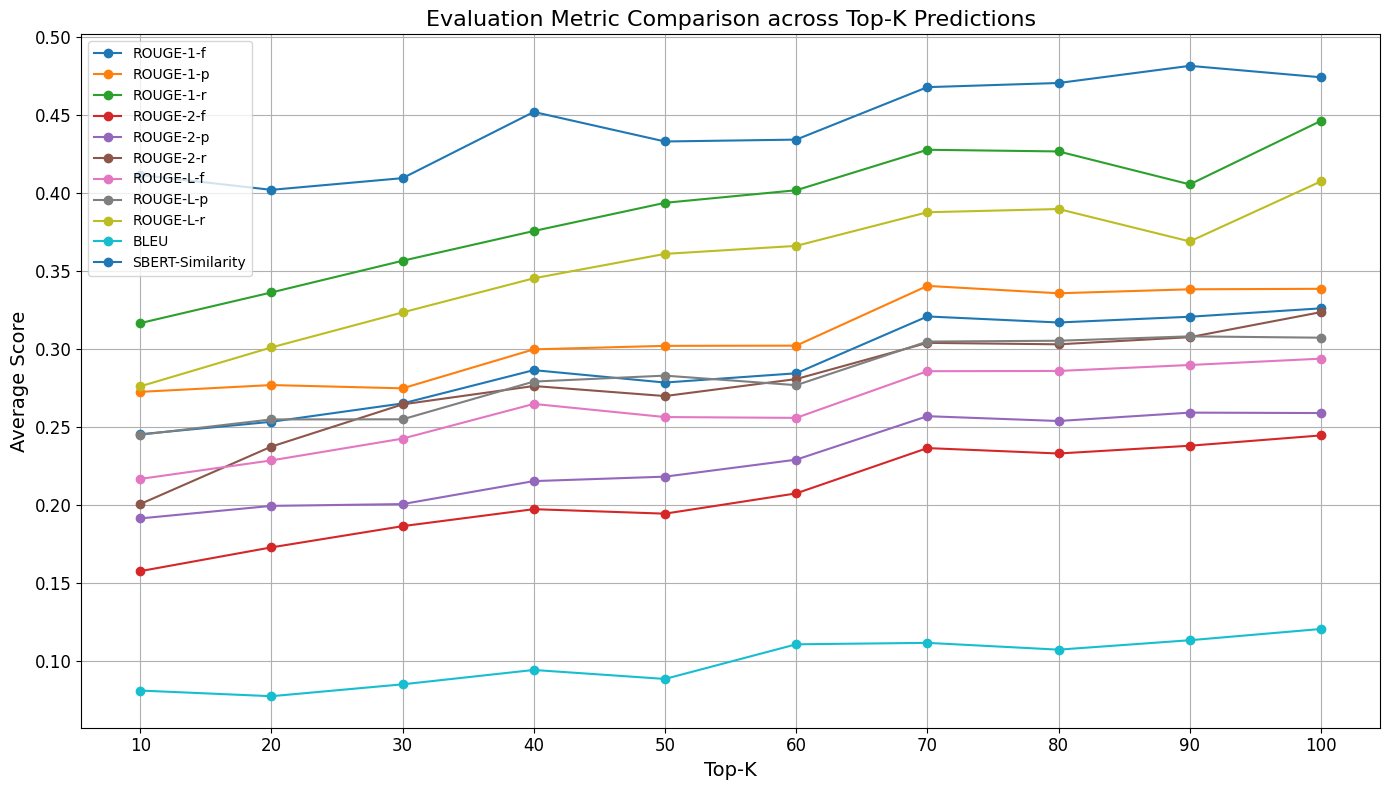

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sentence_transformers import SentenceTransformer, util

# Initialization
rouge = Rouge()
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
smoothing = SmoothingFunction().method1

# Configuration
base_path = "../data/MSE-KG/BM25/"
top_k_list = list(range(10, 101, 10))
results = {}

# Batch processing
for top_k in top_k_list:

    file_name = f"Predicted_Answers_contexts_by_bm25_{top_k}_paragraph_level.xlsx"
    file_path = os.path.join(base_path, file_name)
    
    if not os.path.exists(file_path):
        continue

    df = pd.read_excel(file_path)

    # Initialize metric columns
    for metric in [
        "ROUGE-1-f", "ROUGE-1-p", "ROUGE-1-r",
        "ROUGE-2-f", "ROUGE-2-p", "ROUGE-2-r",
        "ROUGE-L-f", "ROUGE-L-p", "ROUGE-L-r",
        "BLEU", "SBERT-Similarity"
    ]:
        df[metric] = 0.0

    for i, row in df.iterrows():
        generated = str(row["Answer"])
        ground_truth = str(row["Ground Truth"])

        try:
            rouge_scores = rouge.get_scores(generated, ground_truth)[0]
            df.at[i, "ROUGE-1-f"] = rouge_scores["rouge-1"]["f"]
            df.at[i, "ROUGE-1-p"] = rouge_scores["rouge-1"]["p"]
            df.at[i, "ROUGE-1-r"] = rouge_scores["rouge-1"]["r"]
            df.at[i, "ROUGE-2-f"] = rouge_scores["rouge-2"]["f"]
            df.at[i, "ROUGE-2-p"] = rouge_scores["rouge-2"]["p"]
            df.at[i, "ROUGE-2-r"] = rouge_scores["rouge-2"]["r"]
            df.at[i, "ROUGE-L-f"] = rouge_scores["rouge-l"]["f"]
            df.at[i, "ROUGE-L-p"] = rouge_scores["rouge-l"]["p"]
            df.at[i, "ROUGE-L-r"] = rouge_scores["rouge-l"]["r"]
        except:
            continue

        try:
            bleu = sentence_bleu([ground_truth.split()], generated.split(), smoothing_function=smoothing)
            df.at[i, "BLEU"] = bleu
        except:
            df.at[i, "BLEU"] = 0.0

        try:
            emb_gt = sbert_model.encode(ground_truth, convert_to_tensor=True, show_progress_bar=False)
            emb_gen = sbert_model.encode(generated, convert_to_tensor=True, show_progress_bar=False)
            sim = util.pytorch_cos_sim(emb_gt, emb_gen).item()
            df.at[i, "SBERT-Similarity"] = sim
        except:
            df.at[i, "SBERT-Similarity"] = 0.0

    # Save evaluated results for each file
    evaluated_file = os.path.join(base_path, f"Evaluated_Predicted_Answers_contexts_by_bm25_{top_k}_paragraph_level.xlsx")
    df.to_excel(evaluated_file, index=False)

    # Calculate averages for summary
    avg_scores = df[[
        "ROUGE-1-f", "ROUGE-1-p", "ROUGE-1-r",
        "ROUGE-2-f", "ROUGE-2-p", "ROUGE-2-r",
        "ROUGE-L-f", "ROUGE-L-p", "ROUGE-L-r",
        "BLEU", "SBERT-Similarity"
    ]].mean()
    results[top_k] = avg_scores.to_dict()

    # Plot for current topK
    plt.figure(figsize=(12, 6))
    avg_scores.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"Top-{top_k} Evaluation Metrics", fontsize=16)
    plt.ylabel("Average Score", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.close()

# Create summary table of averages
result_df = pd.DataFrame(results).T
result_df.index.name = "Top-K"
result_df.to_excel("../data/MSE-KG/BM25/Evaluation_Comparison_Averages_BM25_Paragraph_Level.xlsx")

# Plot comparison across all Top-K values
plt.figure(figsize=(14, 8))
for metric in result_df.columns:
    plt.plot(result_df.index, result_df[metric], marker='o', label=metric)

plt.title("Evaluation Metric Comparison across Top-K Predictions", fontsize=16)
plt.xlabel("Top-K", fontsize=14)
plt.ylabel("Average Score", fontsize=14)
plt.xticks(result_df.index, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig("../data/MSE-KG/BM25/Evaluation_Comparison_Averages_BM25_Paragraph_Level.png")
plt.show()

## Sentence-Level Evaluation

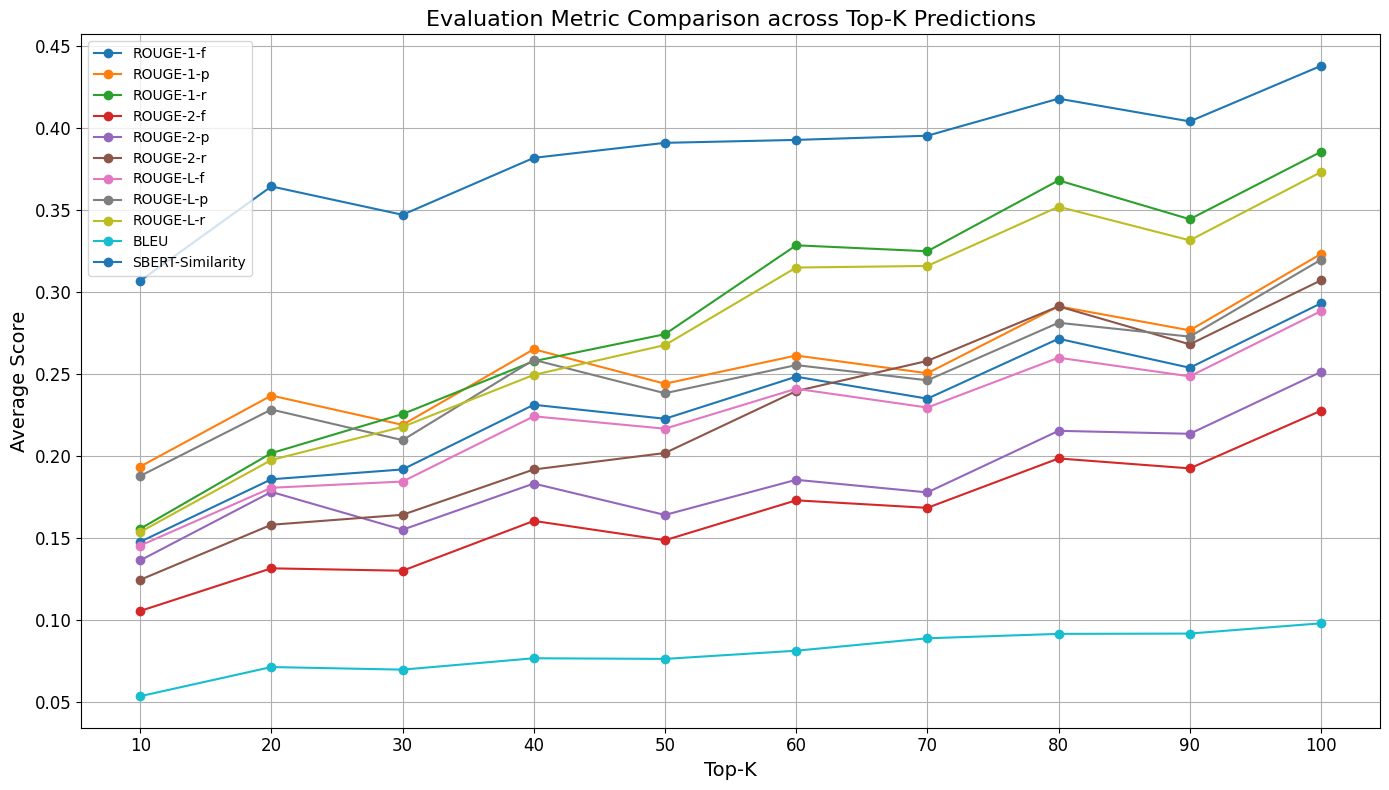

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sentence_transformers import SentenceTransformer, util

# Initialization
rouge = Rouge()
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')
smoothing = SmoothingFunction().method1

# Configuration
base_path = "../data/MSE-KG/BM25/"
top_k_list = list(range(10, 101, 10))
results = {}

# Batch processing
for top_k in top_k_list:

    file_name = f"Predicted_Answers_contexts_by_bm25_{top_k}_sentence_level.xlsx"
    file_path = os.path.join(base_path, file_name)
    
    if not os.path.exists(file_path):
        continue

    df = pd.read_excel(file_path)

    # Initialize metric columns
    for metric in [
        "ROUGE-1-f", "ROUGE-1-p", "ROUGE-1-r",
        "ROUGE-2-f", "ROUGE-2-p", "ROUGE-2-r",
        "ROUGE-L-f", "ROUGE-L-p", "ROUGE-L-r",
        "BLEU", "SBERT-Similarity"
    ]:
        df[metric] = 0.0

    for i, row in df.iterrows():
        generated = str(row["Answer"])
        ground_truth = str(row["Ground Truth"])

        try:
            rouge_scores = rouge.get_scores(generated, ground_truth)[0]
            df.at[i, "ROUGE-1-f"] = rouge_scores["rouge-1"]["f"]
            df.at[i, "ROUGE-1-p"] = rouge_scores["rouge-1"]["p"]
            df.at[i, "ROUGE-1-r"] = rouge_scores["rouge-1"]["r"]
            df.at[i, "ROUGE-2-f"] = rouge_scores["rouge-2"]["f"]
            df.at[i, "ROUGE-2-p"] = rouge_scores["rouge-2"]["p"]
            df.at[i, "ROUGE-2-r"] = rouge_scores["rouge-2"]["r"]
            df.at[i, "ROUGE-L-f"] = rouge_scores["rouge-l"]["f"]
            df.at[i, "ROUGE-L-p"] = rouge_scores["rouge-l"]["p"]
            df.at[i, "ROUGE-L-r"] = rouge_scores["rouge-l"]["r"]
        except:
            continue

        try:
            bleu = sentence_bleu([ground_truth.split()], generated.split(), smoothing_function=smoothing)
            df.at[i, "BLEU"] = bleu
        except:
            df.at[i, "BLEU"] = 0.0

        try:
            emb_gt = sbert_model.encode(ground_truth, convert_to_tensor=True, show_progress_bar=False)
            emb_gen = sbert_model.encode(generated, convert_to_tensor=True, show_progress_bar=False)
            sim = util.pytorch_cos_sim(emb_gt, emb_gen).item()
            df.at[i, "SBERT-Similarity"] = sim
        except:
            df.at[i, "SBERT-Similarity"] = 0.0

    # Save evaluated results for each file
    evaluated_file = os.path.join(base_path, f"Evaluated_Predicted_Answers_contexts_by_bm25_{top_k}_sentence_level.xlsx")
    df.to_excel(evaluated_file, index=False)

    # Calculate averages for summary
    avg_scores = df[[
        "ROUGE-1-f", "ROUGE-1-p", "ROUGE-1-r",
        "ROUGE-2-f", "ROUGE-2-p", "ROUGE-2-r",
        "ROUGE-L-f", "ROUGE-L-p", "ROUGE-L-r",
        "BLEU", "SBERT-Similarity"
    ]].mean()
    results[top_k] = avg_scores.to_dict()

    # Plot for current topK
    plt.figure(figsize=(12, 6))
    avg_scores.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f"Top-{top_k} Evaluation Metrics", fontsize=16)
    plt.ylabel("Average Score", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.close()

# Create summary table of averages
result_df = pd.DataFrame(results).T
result_df.index.name = "Top-K"
result_df.to_excel("../data/MSE-KG/BM25/Evaluation_Comparison_Averages_BM25_Sentence_Level.xlsx")

# Plot comparison across all Top-K values
plt.figure(figsize=(14, 8))
for metric in result_df.columns:
    plt.plot(result_df.index, result_df[metric], marker='o', label=metric)

plt.title("Evaluation Metric Comparison across Top-K Predictions", fontsize=16)
plt.xlabel("Top-K", fontsize=14)
plt.ylabel("Average Score", fontsize=14)
plt.xticks(result_df.index, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.savefig("../data/MSE-KG/BM25/Evaluation_Comparison_Averages_BM25_Sentence_Level.png")
plt.show()